In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from torch.utils.data import DataLoader,  TensorDataset
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing
from torchsummary import summary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import dc_library as dcl

In [2]:
object_table = dcl.load_table(have_images = True)

table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 142963 with all features used in Savic+23
Keeping 142855 with available cutouts


In [3]:
X = object_table.drop(columns=["class", "label"])
y = object_table["label"].to_numpy().astype('int32')
objectID = object_table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

In [17]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test = train_test_split(X, y, 
                                objectID, test_size = 0.5, random_state = 1406)
                    
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
display(X_train.shape, X_test.shape)

(71427, 62)

(71428, 62)

## Load_images

In [53]:
def load_image(objectID, crop = 16, image_shape = 64,
               homedir = os.path.expanduser("~/DATA/data_challenge/cutouts")):
    images = []
    bordo = int((image_shape-crop)/2)
    for i, name in enumerate(objectID):
        filename = name+ ".npy"
        image = np.load(os.path.join(homedir, filename))
        image = image[bordo:image_shape-bordo, bordo:image_shape-bordo, :]
        images.append(image/255)
    return images
        


In [54]:
train_images = load_image(objectID_train)
test_images = load_image(objectID_test)

train_images_t = torch.empty((len(train_images), 16, 16, 3), dtype=torch.float32)
test_images_t = torch.empty((len(test_images), 16, 16, 3), dtype=torch.float32)
for i, image in enumerate(train_images):
    train_images_t[i,:,:,:] = torch.from_numpy(image)
    
for i, image in enumerate(test_images):
    test_images_t[i,:,:,:] = torch.from_numpy(image)

train_images_t = torch.permute(train_images_t, (0, 3, 1, 2))
test_images_t = torch.permute(test_images_t, (0, 3, 1, 2))   

del test_images
del train_images

In [55]:
y_train_t = torch.tensor(y_train, dtype = torch.int64)
y_test_t = torch.tensor(y_test, dtype = torch.int64)
y_train_t =y_train_t.type(torch.LongTensor)
y_test_t =y_test_t.type(torch.LongTensor)

train_dataset = TensorDataset(train_images_t, y_train_t)
test_dataset = TensorDataset(test_images_t, y_test_t)

In [56]:
class savic_cnn(nn.Module):
    def __init__(self):
        super(savic_cnn, self).__init__()
        
        self.cnn = nn.Sequential(
                    nn.Conv2d(3, 12, kernel_size = 2),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.dense = nn.Sequential(
                     nn.Linear(12*7*7, 30),
                     nn.ReLU(),
                     nn.Linear(30, 30),
                     nn.ReLU(),
                     nn.Linear(30,3))
    
    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x

In [57]:
def train_routine(dataloader, model, loss_fn, optimizer, verbose = True):
    losses = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (features, labels) in enumerate(dataloader): #X[0] = tensor with features, X[1] = labels
        output = model(features)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())
            if verbose:
                print(f"loss: {loss:>7f}")

    return losses

def test_routine(dataloader, model, loss_fn, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for features, labels in dataloader:
            output = model(features)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

In [62]:
my_cnn = savic_cnn()
BATCHSIZE = 35
BATCHSIZE_TEST = 100
EPOCHS = 30
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(my_cnn.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size= BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)


In [63]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_routine(train_dataloader, my_cnn, loss_fn, optimizer, verbose = False))
    test_loss.append(test_routine(test_dataloader, my_cnn, loss_fn, verbose = True))
    print(f"Epoch {t}")
print("Done!")

 Avg test loss      : 1.074882
Epoch 0
 Avg test loss      : 1.064767
Epoch 1
 Avg test loss      : 1.048781
Epoch 2
 Avg test loss      : 0.991263
Epoch 3
 Avg test loss      : 0.811058
Epoch 4
 Avg test loss      : 0.679540
Epoch 5
 Avg test loss      : 0.595549
Epoch 6
 Avg test loss      : 0.515952
Epoch 7
 Avg test loss      : 0.441146
Epoch 8
 Avg test loss      : 0.386795
Epoch 9
 Avg test loss      : 0.354900
Epoch 10
 Avg test loss      : 0.336946
Epoch 11
 Avg test loss      : 0.326827
Epoch 12
 Avg test loss      : 0.319072
Epoch 13
 Avg test loss      : 0.311093
Epoch 14
 Avg test loss      : 0.304160
Epoch 15
 Avg test loss      : 0.298556
Epoch 16
 Avg test loss      : 0.294493
Epoch 17
 Avg test loss      : 0.290348
Epoch 18
 Avg test loss      : 0.286313
Epoch 19
 Avg test loss      : 0.284226
Epoch 20
 Avg test loss      : 0.280120
Epoch 21
 Avg test loss      : 0.277532
Epoch 22
 Avg test loss      : 0.275349
Epoch 23
 Avg test loss      : 0.273519
Epoch 24
 Avg test 

[0.91121676 0.95098371 0.82881459]
0.9070392563140505


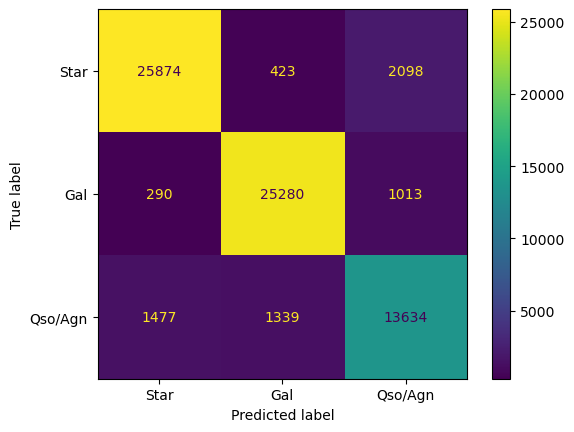

In [69]:
predictions = my_cnn(test_images_t)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test, predictions)

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot()


## Tabular + Images data

In [65]:
idx = 100

x_short= torch.tensor(X_train[:idx], dtype = torch.float32)
y_short = y_train_t[:idx]
img_short = train_images_t[:idx]

In [52]:
class general_MLP(nn.Module):
    def __init__(self, input_size, output_size, N_hidden = 0, hidden_sizes =[],
                activation_function = nn.LeakyReLU(), seed = 26052013):
        super(general_MLP, self).__init__()
        
        self.seed = seed
        
        if N_hidden > 0:
            assert len(hidden_sizes) == N_hidden
            first_layer_out = hidden_sizes[0]
            last_layer_in = hidden_sizes[-1]
        else:
            first_layer_out = output_size 
            last_layer_in = output_size 
        
        self.activation_function = activation_function
        
        self.first_layer = nn.Sequential(
                           nn.Linear(input_size, first_layer_out),
                           self.activation_function)
        

        
        hidden_layers =[]
        for N_in, N_out  in zip(hidden_sizes[:-1],hidden_sizes[1:]):
            
            hidden_layers.append(nn.Linear(N_in, N_out))
            hidden_layers.append(self.activation_function)
       
        
        self.hidden_layers = nn.Sequential(*hidden_layers)

        self.last_layer = nn.Linear(last_layer_in, output_size)
        
        
    def forward(self, x):
        x = self.first_layer(x)
        x = self.hidden_layers(x)
        x = self.last_layer(x)
        
        return x

In [96]:
class final_model(nn.Module):
    def __init__(self):
        super(final_model,self).__init__()
        
        self.process_tabular = general_MLP(input_size = 62, output_size = 30, N_hidden = 1, hidden_sizes =[62],
                activation_function = nn.LeakyReLU())
        
        self.process_image = nn.Sequential(
                                   #nn.Conv2d(3, 12, 2),
                                   #nn.LeakyReLU(),
                                   nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.process_flattened_image = general_MLP(input_size = 3*8*8, output_size = 30, 
                                                   N_hidden = 1, hidden_sizes =[30])
        
        self.process_both = general_MLP(input_size = 60, output_size = 3, 
                                                   N_hidden = 1, hidden_sizes =[30])
        
    def forward(self, image, tabular):
        
        image = self.process_image(image)
        image = torch.flatten(image, 1)
        image = self.process_flattened_image(image)
        
        tabular = self.process_tabular(tabular)
        
        out = torch.concat([image, tabular], dim =1)
        
        return out

In [97]:
X_train_t = torch.tensor(X_train, dtype = torch.float32)
X_test_t = torch.tensor(X_test, dtype = torch.float32)

train_dataset_final = TensorDataset(train_images_t, X_train_t, y_train_t)
test_dataset_final = TensorDataset(test_images_t, X_test_t, y_test_t)

train_dataloader_final = DataLoader(train_dataset_final, batch_size= 35, shuffle=True)
test_dataloader_final = DataLoader(test_dataset_final, batch_size= 35, shuffle=True)


In [98]:
def train_routine_final(dataloader, model, loss_fn, optimizer, verbose = True):
    losses = []
    num_batches = len(dataloader)
    for batch, (images, features, labels) in enumerate(dataloader): #X[0] = tensor with features, X[1] = labels
        output = model(images, features)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())
            if verbose:
                print(f"loss: {loss:>7f}")

    return losses

def test_routine_final(dataloader, model, loss_fn, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for images, features, labels in dataloader:
            output = model(images, features)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

In [99]:
modello_finale = final_model()
EPOCHS = 60
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(modello_finale.parameters(), lr=0.001)

In [100]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_routine_final(train_dataloader_final, modello_finale, loss_fn, optimizer, verbose = False))
    test_loss.append(test_routine_final(test_dataloader_final, modello_finale, loss_fn, verbose = True))
    print(f"Epoch {t}")
print("Done!")

 Avg test loss      : 1.669285
Epoch 0
 Avg test loss      : 1.008101
Epoch 1
 Avg test loss      : 0.840340
Epoch 2
 Avg test loss      : 0.740172
Epoch 3
 Avg test loss      : 0.664936
Epoch 4
 Avg test loss      : 0.604668
Epoch 5
 Avg test loss      : 0.555502
Epoch 6
 Avg test loss      : 0.514498
Epoch 7
 Avg test loss      : 0.480878
Epoch 8
 Avg test loss      : 0.453632
Epoch 9
 Avg test loss      : 0.431935
Epoch 10
 Avg test loss      : 0.414534
Epoch 11
 Avg test loss      : 0.400855
Epoch 12
 Avg test loss      : 0.389628
Epoch 13
 Avg test loss      : 0.380668
Epoch 14
 Avg test loss      : 0.373238
Epoch 15
 Avg test loss      : 0.367080
Epoch 16
 Avg test loss      : 0.361943
Epoch 17
 Avg test loss      : 0.357560
Epoch 18
 Avg test loss      : 0.353679
Epoch 19
 Avg test loss      : 0.350228
Epoch 20
 Avg test loss      : 0.347183
Epoch 21
 Avg test loss      : 0.344536
Epoch 22
 Avg test loss      : 0.341803
Epoch 23
 Avg test loss      : 0.339177
Epoch 24
 Avg test 

[0.90339849 0.95425648 0.7725228 ]
0.8921851374810998


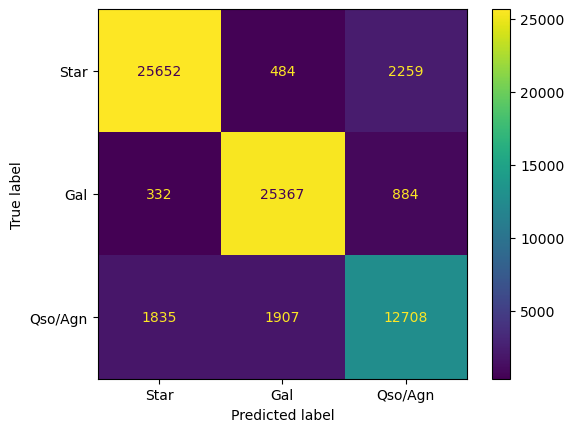

In [101]:
predictions = modello_finale(test_images_t, X_test_t)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test, predictions)

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot()


In [102]:
(64-16)/2

24.0

In [103]:
?str.zfill

Signature: str.zfill(self, width, /)
Docstring:
Pad a numeric string with zeros on the left, to fill a field of the given width.

The string is never truncated.
Type:      method_descriptor